# Crypto modelling with Keras

In this notebook, we try to predict the ETH price (in USD) for the last 7 days (test set), utilising all the previous data (up to 2015) as training data. 

In [1]:
import pandas as pd
# import the relevant Keras modules
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import html5lib
import lxml
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# get market info for ethereum from the start of 2016 to the current day
url = "https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d")
print(url)
eth_market_info = pd.read_html(url)[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end=20180206


Date     Open     High     Low    Close      Volume    Market Cap
0 2018-02-05   834.96   856.65  644.60   697.95  4269530000   81337400000
1 2018-02-04   964.67   969.03  805.06   834.68  2997090000   93953400000
2 2018-02-03   919.21   991.94  847.69   964.02  3243480000   89507600000
3 2018-02-02  1035.77  1035.77  757.98   915.78  6713290000  100836000000
4 2018-02-01  1119.37  1161.35  984.82  1036.79  5261680000  108952000000

In [3]:
#eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [4]:
# Compuate volatility as (high - low) / open
kwargs = {
    'close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
    'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)

In [5]:
model_data = eth_market_info[['Date','Close','Volume','close_off_high','volatility']].copy()
model_data = model_data.sort_values(by='Date')

In [6]:
model_data.head()

Date     Close   Volume  close_off_high  volatility
913 2015-08-07  2.770000   164329        0.509804    0.360424
912 2015-08-08  0.753325   674188        0.962979    0.747410
911 2015-08-09  0.701897   532170        0.419789    0.354916
910 2015-08-10  0.708448   405283       -0.541175    0.130685
909 2015-08-11  1.070000  1463100       -0.742911    0.659192

In [27]:
# we don't need the date columns anymore
split_date = '2018-01-01'
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [28]:
window_len = 7
norm_cols = ['Close','Volume']

In [29]:
def create_inputs_outputs_LSTM(dataset, window_len1):
    # Dividing in chunks of size == window
    LSTM_training_inputs = []
    for i in range(len(dataset)-window_len1):
        temp_set = dataset[i:(i+window_len1)].copy()
        # normalizing columns
        for col in norm_cols:            
            temp_set[col]= temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_training_inputs.append(temp_set)
    LSTM_training_outputs = (dataset['Close'][window_len1:].values/dataset['Close'][:-window_len1].values)-1
    
    return [LSTM_training_inputs, LSTM_training_outputs]

In [30]:
LSTM_training_inputs,LSTM_training_outputs = create_inputs_outputs_LSTM(training_set, window_len)
LSTM_test_inputs, LSTM_test_outputs = create_inputs_outputs_LSTM(test_set, window_len)

In [31]:
print(LSTM_training_inputs[0])
print(LSTM_test_inputs[0])

        Close     Volume  close_off_high  volatility
913  0.000000   0.000000        0.509804    0.360424
912 -0.728042   3.102672        0.962979    0.747410
911 -0.746608   2.238442        0.419789    0.354916
910 -0.744243   1.466290       -0.541175    0.130685
909 -0.613718   7.903480       -0.742911    0.659192
908 -0.559567  12.087282       -0.655505    0.383389
907 -0.339350  23.759355       -0.650000    0.655738
       Close    Volume  close_off_high  volatility
35  0.000000  0.000000       -0.511966    0.053628
34  0.144699  1.227999       -0.573414    0.184476
33  0.246014  0.962107       -0.778344    0.119661
32  0.269569  1.505185        0.296293    0.102931
31  0.291313  1.574641        0.304720    0.122019
30  0.348209  0.796091       -0.424119    0.066412
29  0.492506  1.145761       -1.000000    0.105617


In [32]:
# Easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [33]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    shape1 = (inputs.shape[1], inputs.shape[2])
    print(shape1)
    model.add(LSTM(neurons, input_shape=shape1))
    
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [34]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

(7, 4)
Epoch 1/5
 - 8s - loss: 0.1081
Epoch 2/5
 - 6s - loss: 0.0748
Epoch 3/5
 - 6s - loss: 0.0707
Epoch 4/5
 - 6s - loss: 0.0668
Epoch 5/5
 - 7s - loss: 0.0644


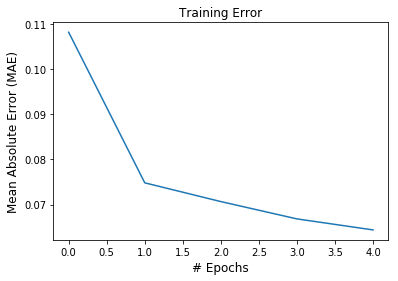

In [35]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

In [36]:
actual_datetime = model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime)
actual_values = training_set['Close'][window_len:]

predicted_datetime = model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime)
predicted_values = ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0]

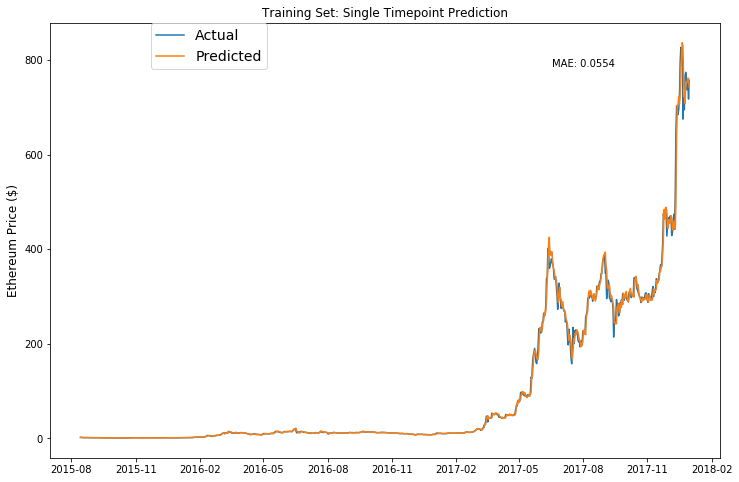

In [37]:
# TODO - simplify plot for GODSAKE
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1,figsize=(12,8))

ax1.plot(actual_datetime, actual_values, label='Actual')
ax1.plot(predicted_datetime, predicted_values, label='Predicted')

ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')

plt.show()

In [43]:
actual_datetime_test = model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)
actual_values_test = test_set['Close'][window_len:]

predicted_datetimes_test = model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)
predicted_values_test = ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0]

In [44]:
LSTM_test_inputs.shape

(29, 7, 4)

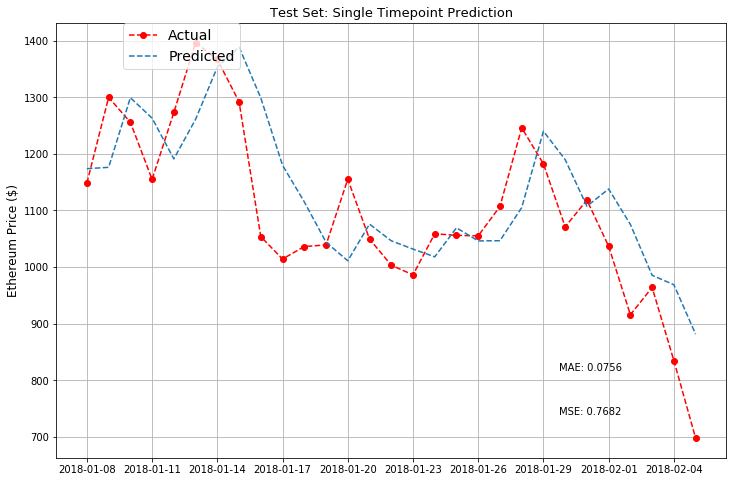

In [47]:
fig, ax1 = plt.subplots(1,1, figsize=(12,8))

ax1.plot(actual_datetime_test, actual_values_test, '--ro',label='Actual')
ax1.plot(predicted_datetimes_test, predicted_values_test, '--',label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.2),  xycoords='axes fraction',
            xytext=(0.75, 0.2), textcoords='axes fraction')
ax1.annotate('MSE: %.4f'%np.mean(((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len])).sum()), 
             xy=(0.75, 0.1),  xycoords='axes fraction',
            xytext=(0.75, 0.1), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.grid()
plt.show()

In [48]:
# Predicting 7 days in advance
#We'll now build LSTM models to predict crypto prices for the next 7 days.

# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 7
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 7 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)


(7, 4)
Epoch 1/5
 - 8s - loss: 0.1618
Epoch 2/5
 - 6s - loss: 0.1373
Epoch 3/5
 - 6s - loss: 0.1304
Epoch 4/5
 - 6s - loss: 0.1264
Epoch 5/5
 - 6s - loss: 0.1280


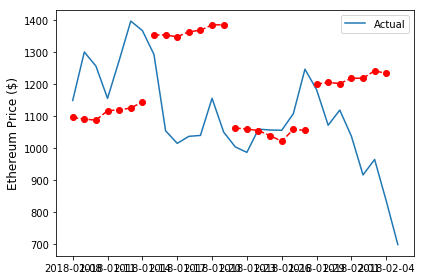

In [66]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::pred_range].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

fig, ax2 = plt.subplots(1,1)
#ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['Close'][window_len:], label='Actual')
for i, eth_pred in enumerate(eth_pred_prices):
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, '--ro')

ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax2.legend()
fig.tight_layout()
plt.show()

In [71]:
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::pred_range]
                   .reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

In [85]:
print(pred_range)
(eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range])

7


array([[ 0.41745916,  0.4111639 ,  0.4065668 ,  0.44493005,  0.44826913,
         0.45580652,  0.48023742],
       [ 0.17790274,  0.17797989,  0.1731943 ,  0.18674013,  0.19072022,
         0.20558102,  0.20562842],
       [-0.17776136, -0.18016094, -0.18396583, -0.19609787, -0.20985776,
        -0.18101221, -0.18344022],
       [ 0.19554499,  0.20087424,  0.19736908,  0.21374986,  0.2140194 ,
         0.23718603,  0.22877827]], dtype=float32)

In [81]:
np.array([1,2,3,4,5,6,7,8])[::2]

array([1, 3, 5, 7])